# Warning: if you are using Colab

If you are currently running on Colab, you need to install ```tensorflow``` v-2.1.0 (the default version  on Colab is v-2.2.0) and ```keract``` beforehand.

In [1]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.2.0rc1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.2.0rc1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
Proceed (y/n)? y
y
  Successfully uninstalled tensorflow-2.2.0rc1


In [2]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 16kB/s 
     |████████████████████████████████| 450kB 52.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=6a48fd26b58c114efa56eae3e2f4aa83b753f27f46e76db47f501c932cb229d9
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0


In [3]:
!pip install keract

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os 
os.chdir('/content/drive/My Drive/MVA/S2/DLMI')

# Imports

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import tensorflow_addons as tfa
import keract
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score
import keras
import tensorflow as tf
from utils.evaluation import *
from utils.utils import read_dataset,split_dataset,visualize_transplant

Using TensorFlow backend.


# 1. Data importation and visualization

In [0]:
xtrain,ytrain,xval,yval,y_val_true,xtest,ytest,y_test_true,cols = np.load('data/transplant_10col.npy',
                                                                          allow_pickle=True)

In [9]:
xtrain.shape,xtest.shape

((264, 1082, 10), (33, 1082, 10))

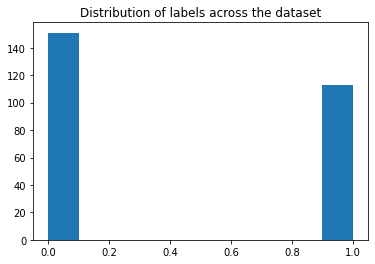

In [10]:
plt.hist(ytrain)
plt.title('Distribution of labels across the dataset')
plt.show()

In [11]:
unique_labels,props = np.unique(ytrain,return_counts=True)
df_props = pd.DataFrame([],columns=['proportion'],index = unique_labels)
df_props.index.name='label'
df_props['proportion'] = props/np.sum(props)
df_props

,proportion
label,
0,0.57197
1,0.42803


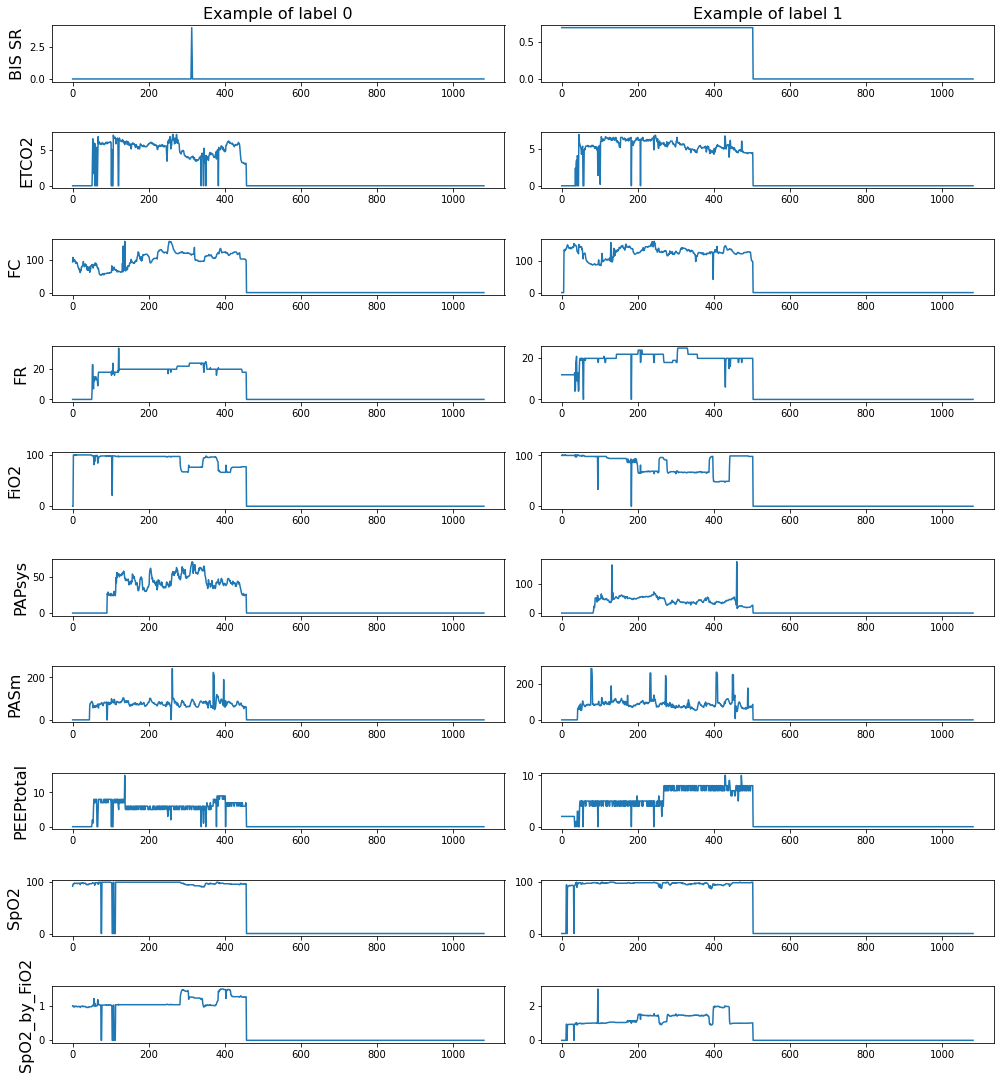

In [14]:
visualize_transplant(xtrain,ytrain,cols)

# 2. Splitting dataset

Our dataset has already been splitted using a stratified shuffle split, to respect the labels distribution.

# 3. Testing models

## 3.1 MLP

In [0]:
from models.mlp import Classifier_MLP

### 3.1.1 Training

In [14]:
mlp = Classifier_MLP(output_directory='outputs/output_mlp/',input_shape=(xtrain.shape[1],xtrain.shape[2]),
                     nb_classes = 2,verbose=True,
                     hidden_layers_size=(200,200,200,200))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10820)             0         
_________________________________________________________________
dropout (Dropout)            (None, 10820)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               2164200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               4

Train on 264 samples, validate on 33 samples
Epoch 1/100
264/264 [==============================] - 1s 4ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 2/100
264/264 [==============================] - 1s 3ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 3/100
264/264 [==============================] - 0s 286us/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 4/100
264/264 [==============================] - 0s 270us/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 5/100
264/264 [==============================] - 0s 250us/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 6/100
264/264 [==============================] - 0s 252us/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 7/100
264/264 [==============================] - 0s 225us/sample - loss

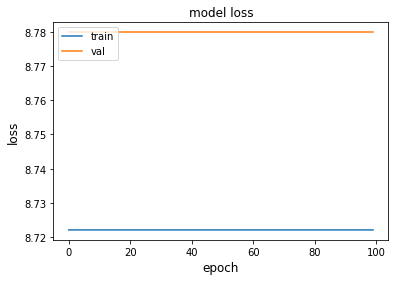

In [15]:
%matplotlib inline
hist = mlp.fit(xtrain,ytrain,xval,yval,y_val_true,batch_size=32,nb_epochs=100)

Let's evaluate our predictions on the validation set: 

In [0]:
mlp_model = tf.keras.models.load_model('outputs/output_mlp/best_model.hdf5')

In [42]:
ypred = mlp_model.predict(xval)
ypred = np.argmax(ypred,axis=1)
evaluate(y_val_true,ypred)

,accuracy,recall,precision,f1-score
0,0.575758,0.5,0.287879,0.365385


### 3.1.2 Evaluating on the test set

In [0]:
mlp_model = tf.keras.models.load_model('outputs/output_mlp/best_model.hdf5')

In [43]:
ypred = mlp_model.predict(xtest)
ypred = np.argmax(ypred,axis=1)
evaluate(y_test_true,ypred)

,accuracy,recall,precision,f1-score
0,0.575758,0.5,0.287879,0.365385


Let's be more precise on each class. The following scores are computed considering each label against all the others.

In [44]:
get_binary_metrics(y_test_true,ypred)

,recall,precision,f1-score
0,1,0.575758,0.730769
1,0,0,0


/content/drive/My Drive/MVA/S2/DLMI/utils/evaluation.py:36: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm/cm.sum(axis=0),3)


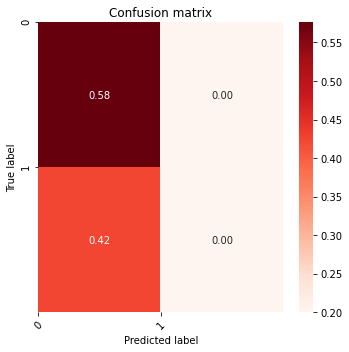

In [45]:
plot_confusion_matrix(y_test_true,ypred)

## 3.2 CNN

In [0]:
from models.CNN_1D import Classifier_1DCNN

### 3.2.1 Training

In [11]:
cnn = Classifier_1DCNN('outputs/output_1DCNN/', nb_classes=2,
                       n_conv_block=3, n_filters=(100,100,100), kern_size=(5,5,5), 
                       n_stride=(1,1,1), 
                       input_shape=(xtrain.shape[1],xtrain.shape[2]), 
                       add_FC=True, n_unit_FC=20,
                       verbose=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1082, 100)         5100      
_________________________________________________________________
batch_normalization (BatchNo (None, 1082, 100)         400       
_________________________________________________________________
activation (Activation)      (None, 1082, 100)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1082, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1082, 100)         50100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1082, 100)         400       
_________________________________________________________________
activation_1 (Activation)    (None, 1082, 100)         0

Train on 264 samples, validate on 33 samples
Epoch 1/200
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
264/264 [==============================] - 11s 43ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 2/200
264/264 [==============================] - 0s 1ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 3/200
264/264 [==============================] - 0s 1ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 4/200
264/264 [==============================] - 0s 1ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 5/200
264/264 [==============================] - 0s 1ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 6/200
264/264 [==============================] - 0s 1ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Ep

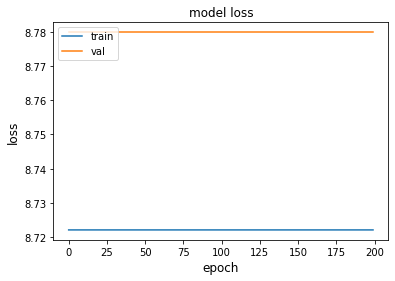

In [12]:
%matplotlib inline
hist = cnn.fit(xtrain,ytrain,xval,yval,y_val_true,batch_size=32,nb_epochs=200)

In [0]:
cnn_model = tf.keras.models.load_model('outputs/output_1DCNN/best_model.hdf5',
                                       custom_objects={'SWA': tfa.optimizers.SWA})

In [61]:
ypred = cnn_model.predict(xval)
ypred = np.argmax(ypred,axis=1)
evaluate(y_val_true,ypred)

,accuracy,recall,precision,f1-score
0,0.575758,0.5,0.287879,0.365385


### 3.2.2 Evaluating on the test set

In [0]:
cnn_model = tf.keras.models.load_model('outputs/output_1DCNN/best_model.hdf5',
                                       custom_objects={'SWA': tfa.optimizers.SWA})

In [62]:
ypred = cnn_model.predict(xtest)
ypred = np.argmax(ypred,axis=1)
evaluate(y_test_true,ypred)

,accuracy,recall,precision,f1-score
0,0.575758,0.5,0.287879,0.365385


Let's be more precise

In [63]:
get_binary_metrics(y_test_true,ypred)

,recall,precision,f1-score
0,1,0.575758,0.730769
1,0,0,0


/content/drive/My Drive/MVA/S2/DLMI/utils/evaluation.py:36: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm/cm.sum(axis=0),3)


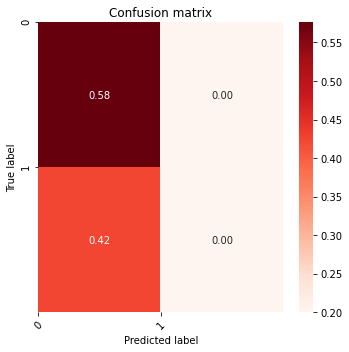

In [64]:
plot_confusion_matrix(y_test_true,ypred)

## 3.3 ResNet

In [0]:
from models.resnet import Classifier_RESNET

### 3.3.1 Training

In [21]:
resnet = Classifier_RESNET('outputs/output_resnet/',input_shape=(xtrain.shape[1],xtrain.shape[2]),
                           nb_classes=2,n_feature_maps = (64,128,128),kernel_size=(8,5,3,2),
                           verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1082, 10)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1082, 64)     5184        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1082, 64)     256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1082, 64)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

Train on 264 samples, validate on 33 samples
Epoch 1/25
264/264 [==============================] - 4s 16ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 2/25
264/264 [==============================] - 1s 3ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 3/25
264/264 [==============================] - 1s 3ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 4/25
264/264 [==============================] - 1s 3ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 5/25
264/264 [==============================] - 1s 3ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 6/25
264/264 [==============================] - 1s 3ms/sample - loss: 8.7221 - accuracy: 0.4280 - val_loss: 8.7799 - val_accuracy: 0.4242
Epoch 7/25
264/264 [==============================] - 1s 4ms/sample - loss: 8.7221 - accur

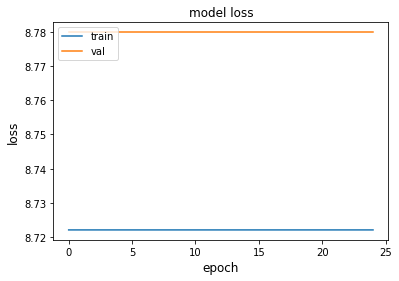

In [22]:
%matplotlib inline
hist = resnet.fit(xtrain,ytrain,xval,yval,y_val_true,batch_size=32,nb_epochs=25)

In [0]:
resnet_model = tf.keras.models.load_model('outputs/output_resnet/best_model.hdf5')

In [24]:
ypred = resnet_model.predict(xval)
ypred = np.argmax(ypred,axis=1)
evaluate(y_val_true,ypred)

,accuracy,recall,precision,f1-score
0,0.575758,0.5,0.287879,0.365385


### 3.3.2 Evaluating on the test set

In [0]:
resnet_model = tf.keras.models.load_model('outputs/output_resnet/best_model.hdf5')

In [25]:
ypred = resnet_model.predict(xtest)
ypred = np.argmax(ypred,axis=1)
evaluate(y_test_true,ypred)

,accuracy,recall,precision,f1-score
0,0.575758,0.5,0.287879,0.365385


In [26]:
get_binary_metrics(y_test_true,ypred)

,recall,precision,f1-score
0,1,0.575758,0.730769
1,0,0,0


/content/drive/My Drive/MVA/S2/DLMI/utils/evaluation.py:36: RuntimeWarning: invalid value encountered in true_divide
  cm = np.round(cm/cm.sum(axis=0),3)


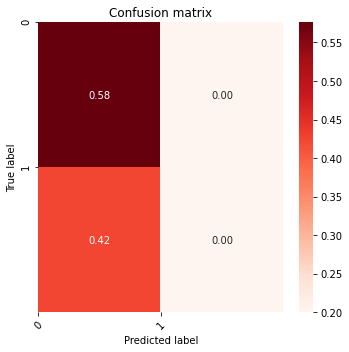

In [27]:
plot_confusion_matrix(y_test_true,ypred)

# 4. Interpreting models

Here we display only the activations for the last layer. Given the models did not learn anything, we do not expect the plots to be meaningful, but we expect them to highlight no particular part of the signals (which would be an indication that they did not learn anything).

In [0]:
from interpretation.cam import display_conv_activations,display_conv_activations_transplant

## 4.1 1D-CNN model

In [0]:
cnn_model = tf.keras.models.load_model('outputs/output_1DCNN/best_model.hdf5',
                                       custom_objects={'SWA': tfa.optimizers.SWA})

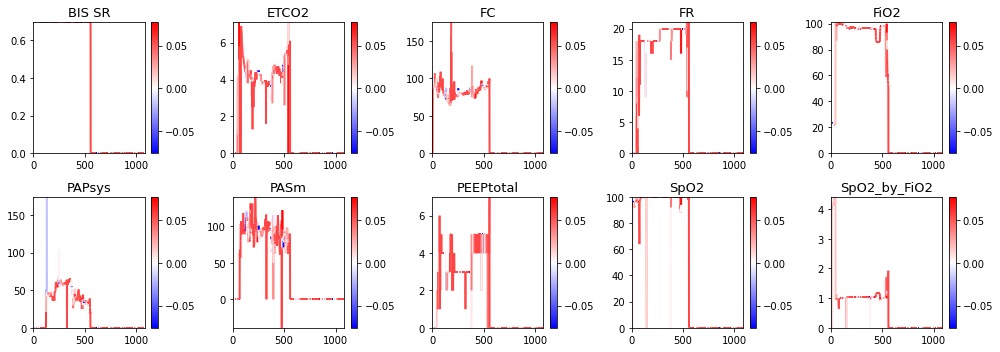

In [19]:
%matplotlib inline
display_conv_activations_transplant(cnn_model,xtest[0],cols)

## 4.2 ResNet model

In [0]:
resnet_model = tf.keras.models.load_model('outputs/output_resnet/best_model.hdf5')

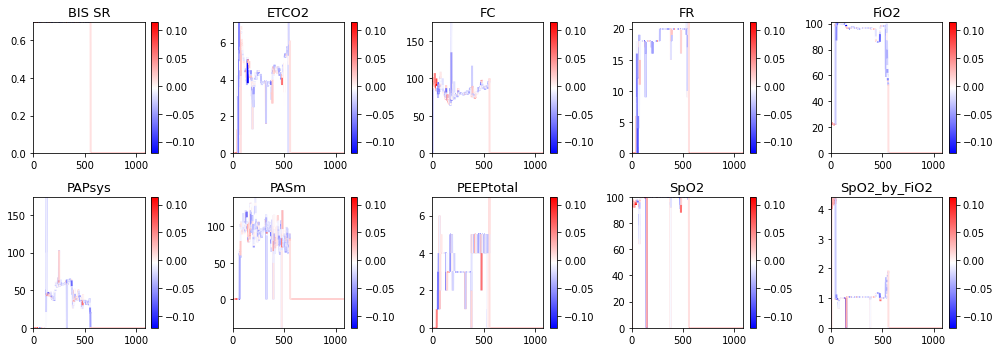

In [29]:
display_conv_activations_transplant(resnet_model,xtest[0],cols)